# Bayesian Hidden Markov Models

This tutorial illustrates training Bayesian Hidden Markov Models (HMM) using *Turing*. The main goals are learning the transition matrix, emission parameter, and hidden states.

Let's load the libraries we'll need. We also set a random seed (for reproducibility) and the automatic differentiation backend to forward mode (more [here](https://github.com/TuringLang/Turing.jl/issues/511) on why this is useful). 

In [1]:
# Load libraries.
using Turing, Plots, Random

# Set a random seed and use the forward_diff AD mode.
Random.seed!(1234);
Turing.setadbackend(:forward_diff);

## Simple State Detection

In this example, we'll use something where the states and emission parameters are very obvious. 

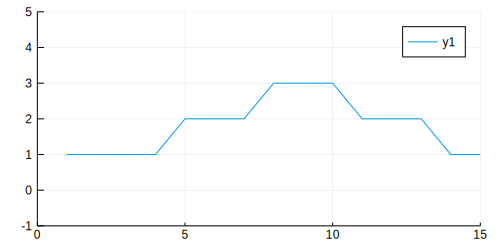

In [2]:
# Define the emission parameter.
y = [ 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 2.0, 2.0, 2.0, 1.0, 1.0 ];
N = length(y);  K = 3;

# Plot the data we just made.
plot(y, xlim = (0,15), ylim = (-1,5), size = (500, 250))

We can see that we have three states, one for each height of the plot (1, 2, 3). This height is also our emission parameter, so state one produces a value of one, state two produces a value of two, and so on.

Ultimately, we would like to understand three major parameters:

1. The transition matrix. This is a matrix that assigns a probability of switching from one state to any other state, including the state that we are already in.
2. The emission matrix, which describes a typical value emitted by some state. In the plot above, the emission parameter for state one is simply one.
3. The state sequence is our understanding of what state we were actually in when we observed some data. This is very important in more sophisticated HMM models.

With this in mind, let's set up our model.

In [7]:
# Turing model definition.
@model BayesHmm(y) = begin
    # State sequence.
    s = tzeros(Int, N)
    
    # Emission matrix.
    m = Vector{Real}(undef, K)
    
    # Transition matrix.
    T = Vector{Vector{Real}}(undef, K)
    
    # Assign distributions to each element 
    # of the transition matrix and the
    # emission matrix.
    for i = 1:K
        T[i] ~ Dirichlet(ones(K)/K)
        m[i] ~ Normal(i, 0.5)
    end
    
    # Observe each point of the input.
    s[1] ~ Categorical(K)
    y[1] ~ Normal(m[s[1]], 0.1)

    for i = 2:N
        s[i] ~ Categorical(vec(T[s[i-1]]))
        y[i] ~ Normal(m[s[i]], 0.1)
    end
    return(s, m)
end;

We will use a combination of two samplers ([HMC](http://turing.ml/docs/library/#Turing.HMC) and [Particle Gibbs](http://turing.ml/docs/library/#Turing.PG)) by passing them to the [Gibbs](http://turing.ml/docs/library/#Turing.Gibbs) sampler. The Gibbs sampler allows for compositional inference, where we can pass samplers across different parameters. In this case, we use HMC for `m` and `T`, representing the emission and transition matrices respectively. We use the Particle Gibbs sampler for `s`, the state sequence.

In [30]:
g = Gibbs(1000, HMC(2, 0.001, 7, :m, :T), PG(20, 1, :s))
c = sample(BayesHmm(y), g);

[Gibbs] Sampling...100% Time: 0:01:23
┌ Info: [Gibbs] Finished with
└ @ Turing /home/cameron/.julia/dev/Turing/src/samplers/gibbs.jl:177
┌ Info:   Running time    = 82.89291160699993;
└ @ Turing /home/cameron/.julia/dev/Turing/src/samplers/gibbs.jl:178


Let's see how well our chain performed. Ordinarily, using the `describe` function from [MCMCChain](https://github.com/TuringLang/MCMCChain.jl) would be a good first step, but we have generated a lot of parameters here. It's a bit easier to show how our model performed graphically.

The code below generates an animation showing the graph of the data above, and the data our model generates in each sample.

In [41]:
# Import StatsPlots for animating purposes.
using StatPlots

# Extract our m and s parameters from the chain.
m_set = c[:m]
s_set = c[:s]

# Iterate through the MCMC samples.
Ns = 1:500

# Make an animation.
animation = @animate for (i, N) in enumerate(Ns)
    m = m_set[N]; s = s_set[N];
    p = plot(y, c = :red,
        size = (500, 250), 
        xlabel = "Time", 
        ylabel = "State", 
        legend = :topright, label = "True data",
        xlim = (0,15),
        ylim = (-1,5)); 
    plot!(p, m[s], c = :blue, label = "Sample $N")
end every 10;

┌ Info: Saved animation to 
│   fn = /home/cameron/code/TuringTutorials/tmp.gif
└ @ Plots /home/cameron/.julia/packages/Plots/cDXot/src/animation.jl:90


Plots.AnimatedGif("/home/cameron/code/TuringTutorials/tmp.gif")

![animation](https://user-images.githubusercontent.com/422990/50612436-de588980-0e8e-11e9-8635-4e3e97c0d7f9.gif)

Looks like our model did a pretty good job, but we should also check to make sure our model converges. A quick check is to examine whether the diagonal (representing the probability of remaining in the current state) of the transition matrix appears to be stationary. The code below extracts the diagonal and shows a traceplot of each persistence probability.

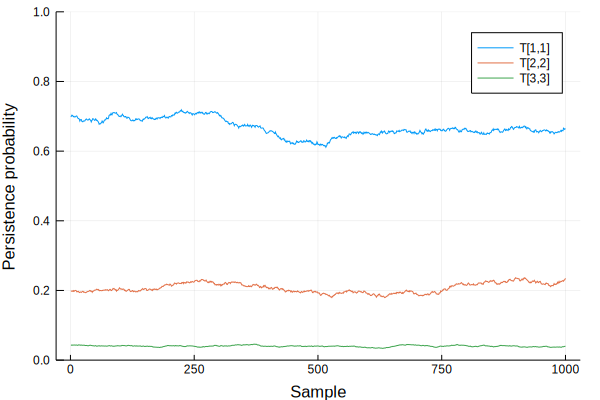

In [31]:
T_diag_trace = [t[i][i] for t in c[:T], i in 1:K];

plot(T_diag_trace, ylim = (0,1),
     label = ["T[$i,$i]" for i = 1:K],
     xlabel = "Sample", ylabel = "Persistence probability")

A cursory examination of the traceplot above indicates that at least `T[3,3]` and possibly `T[2,2]` have converged to something resembling stationary. `T[1,1]`, on the other hand, has a slight "wobble", and seems less consistent than the others. We can use the diagnostic functions provided by [MCMCChain](https://github.com/TuringLang/MCMCChain.jl) to engage in some formal tests, like the Heidelberg and Welch diagnostic:

In [40]:
heideldiag(c)

         Burn-in Stationarity p-value      Mean               Halfwidth          Test
 T[2][1]       0            1  0.1191   0.594049172  0.0219791595732450467659547    1
 T[2][2]       0            1  0.8135   0.207348977  0.0108599207837672077220370    1
 T[2][3]     300            1  0.1091   0.208106958  0.0113804794416929398043203    1
  lf_num     500            0     NaN   7.000000000  0.0000000000000000000000000    1
    s[4]     500            0     NaN   3.000000000  0.0000000000000000000000000    1
    s[2]     500            0     NaN   3.000000000  0.0000000000000000000000000    1
    s[9]     500            0     NaN   2.000000000  0.0000000000000000000000000    1
    s[1]     500            0     NaN   3.000000000  0.0000000000000000000000000    1
    s[6]     500            0     NaN   1.000000000  0.0000000000000000000000000    1
   s[14]     500            0     NaN   3.000000000  0.0000000000000000000000000    1
 T[1][1]     300            1  0.1597   0.653988530  0

The p-values on the test suggest that we cannot reject the hypothesis that the observed sequence comes from a stationary distribution, so we can be somewhat more confident that our transition matrix has converged to something reasonable. 

## Detecting A Fair Coin

Now it's all well and good to plot a line on a nice, clean dataset. But what if we are trying to detect when someone is cheating us in a coin flipping game? 

Let's say we have a friend named Jane. Every once in a while we play a game with Jane where she flips a coin. Jane wins a dollar from us if it's heads, we win a dollar from Jane if it's tails. The problem is that Jane is sometimes a cheater — 10% of the time, she'll bring out a coin that comes up heads 90% of the time, and she decides to switch back to the fair coin 80% of the time so we don't become suspicious. Hidden Markov models are ideal for learning this kind of transition matrix, so let's get to it.

We set up some variables first, namely the transition matrix described in the preceding paragraph, and Bernoulli distributions for each of the coin flip types, fair and unfair.

In [44]:
# Define our fair/unfair coinflip probabilities.
p_heads_fair = 0.5
p_heads_unfair = 0.9

# Setup Bernoulli distributions for our coinflips.
# Note that we use 1 - p, because we
fair = Bernoulli(p_heads_fair);
unfair = Bernoulli(p_heads_unfair);

# Define our transition matrix.
transition_target = [0.9 0.1;
                     0.8 0.2];

The code below generates Jane's sometimes-unfair coinflips. 

In [45]:
function make_flips(num_flips)
    # Create variables to stash our coin flips and states.
    flips = []
    states = []

    # Jane always starts with a fair coin. How nice.
    unfair_coin = false

    # Generate our coin flips.
    for i in 1:num_flips
        # This variable stores the probability of staying with
        # the current coin, fair or unfair.
        success_val = 0

        # Flip the relevant coin and get the success_val.
        if unfair_coin == false
            push!(flips, rand(fair))
            success_val = transition_target[1,1]
        else
            push!(flips, rand(unfair))
            success_val = transition_target[2,2]
        end

        # Add the state we just used to the states variable.
        push!(states, unfair_coin)

        # Calculate whether to stay in our current state.
        new_state = rand(Bernoulli(success_val))

        # If we got a zero in new_state, switch coins.
        if new_state == 0
            unfair_coin = ~unfair_coin
        end
    end

    return (states, flips)
end

# Number of coinflips to observe.
num_flips = 20

# Generate state and flip sequences.
states, flips = make_flips(num_flips);

Time to declare our Turing model. 

You will note that this model is very similar to the one we used in the previous example, but now the emission parameter `m` has two separate `Beta` priors, one showing our belief that there is a fair coin and an unfair coin. This will allow us to model the probability of getting a heads in each state, and establishing them as distinct priors helps to avoid the label-switching problem. 

Additionally, when we observe each data point `y[i]`, we are using the `Bernoulli` distribution, which models this coin-flipping game closer than does the `Normal` dsitribution we used previously.

In [46]:
# Turing model definition.
@model BayesHmmCoins(y) = begin
    num_obs = length(y)
    
    # State sequence.
    s = tzeros(Int, num_obs)
    
    # Emission matrix.
    m = Vector{Real}(undef, 2)
    
    # We define the emission parameters using
    # semi-informative priors here separately
    # to avoid a label-switching problem.
    m[1] ~ Beta(10000,10000)
    m[2] ~ Uniform(0,1)

    # Transition matrix.
    T = Vector{Vector{Real}}(undef, 2)
    
    # Assign semi-informative priors for the transition matrix.
    T[1] ~ Dirichlet([0.5, 0.5])
    T[2] ~ Dirichlet([0.2,0.8])
    
    # Observe each point of the input.
    s[1] ~ Categorical(2)
    for i = 2:num_obs        
        s[i] ~ Categorical(T[s[i-1]])
        y[i] ~ Bernoulli(m[s[i]])
    end
    
    return(s, m)
end;

We reuse the Gibbs sampler as declared above, but with some parameters changed around very slightly. We also use a longer chain due to the complexity of the game we are modelling.

In [47]:
g = Gibbs(1000, HMC(1, 0.01, 7, :m, :T), PG(25, 1, :s))
c2 = sample(BayesHmmCoins(flips), g);

[Gibbs] Sampling...100% Time: 0:00:40
┌ Info: [Gibbs] Finished with
└ @ Turing /home/cameron/.julia/dev/Turing/src/samplers/gibbs.jl:177
┌ Info:   Running time    = 39.54623737100003;
└ @ Turing /home/cameron/.julia/dev/Turing/src/samplers/gibbs.jl:178


### Results

With our chain sampled, it's time to see how we did. We can evaluate our model's performance by looking at the parameters we care about. What do each of the parameters in our HMM model (the transition matrix, emission matrix, or state sequence) tell us?

Jane has already cheated us in the past, so the state sequence matrix won't be very helpful on it's own in future games. The emission matrix tells us how probable a heads is in each state. The transition matrix can use it to determine the probabilities that Jane will cheat us in the future, assuming we know the current state.

So let's check each parameter, starting with the transition matrix. Remember, Jane uses a transition matrix resembling the following:

$$
T = \begin{bmatrix}
    0.90 & 0.10 \\\ 0.80 & 0.20
\end{bmatrix}
$$

We can check this by just taking the average across the chain.

In [48]:
mean(c2[:T])

2-element Array{Array{Float64,1},1}:
 [0.757172, 0.242828]
 [0.732058, 0.267942]

That looks fairly close. We might also plot the difference between the chain's transition matrix and the true transition matrix as a function of time.

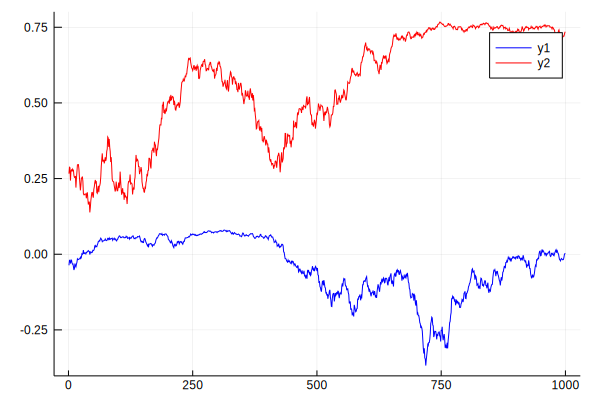

In [115]:
# Use StatPlots for plotting.
using StatPlots

# Extract the transition matrices from the chain.
t_set = c2[:T]

# Get the differences between each sample
# and the true matrix.
ys1 = []
ys2 = []

for i in 1:length(t_set)
    t = t_set[i]
    point1 = t[1][1] - transition_target[1,1]
    point2 = t[2][2] - transition_target[2,2]
    push!(ys1, point1)
    push!(ys2, point2)
end

# Plot the differences.
x_range = collect(1:length(t_set))
plot(x_range, ys1, color=:blue)
plot!(x_range, ys2, color=:red)

Not too shabby, though it looks like we might be systematically underestimating both of the relevant probabilities. How about our emission matrix? Jane has two coins. The first is a fair coin with a 50% chance of turning up heads, and the second is an unfair coin that has a 90% chance of showing heads. Again, let's look at the chain's average.

In [69]:
mean(c2[:m])

2-element Array{Float64,1}:
 0.5466784568597945 
 0.32707110481531415

It looks like we're fairly close to understanding the ways that Jane is cheating us, all thanks to a hidden Markov model implemented in Turing. Perhaps the better lesson here is that Jane is not someone we should be spending time with.